## Importing libraries and defining directory paths

In [ ]:
pip install pynrrd

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import glob
import os
import tensorflow as tf
#import nrrd
import math
import cv2

from math import sqrt
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import NumpyArrayIterator
from numpy import save
from numpy import load
from sklearn.linear_model import LinearRegression
from tensorflow.keras.utils import array_to_img
from tensorflow.keras.utils import img_to_array
import scipy

In [ ]:
CT_volume_path = '/content/drive/MyDrive/Thesis_2/Test_CT/'
CT_mask_path = '/content/drive/MyDrive/Thesis_2/Test_CT_mask/'
Numpy_array_path = '/content/drive/MyDrive/Thesis_2/Test_zscore/'
window_target_path = '/content/drive/MyDrive/Thesis_2/Window_CT_arrays_Model1/'
highres_target_path = '/content/drive/MyDrive/Thesis_2/Highres_array_Model1/'
test_mask_path = '/content/drive/MyDrive/Thesis_2/Test_mask/'
window_validation_path = '/content/drive/MyDrive/Thesis_2/Window_CT_arrays_Model1Val/'
highres_validation_path = '/content/drive/MyDrive/Thesis_2/Highres_array_Model1Val/'


In [ ]:
ct_arr = np.load('/content/drive/MyDrive/COVID_19/images_medseg.npy')
ct_mask = np.load('/content/drive/MyDrive/COVID_19/masks_medseg.npy')

In [ ]:
np.min(ct_arr),np.max(ct_arr)

(-1606.5217391304348, 597.8046699576582)

In [ ]:
inv_ct_mask = 1 - ct_mask

In [ ]:
HU_MIN = -1400
HU_MAX = -200

In [ ]:
ct_arr = np.where(ct_arr<HU_MIN,HU_MIN,ct_arr)
ct_arr = np.where(ct_arr>HU_MAX,HU_MAX,ct_arr)

In [ ]:
HU_RANGE = HU_MAX - HU_MIN
norm_ct_arr = (ct_arr - HU_MIN)/HU_RANGE
np.min(norm_ct_arr),np.max(norm_ct_arr)

(0.0, 1.0)

In [ ]:
lr_input_path = '/content/drive/MyDrive/COVID_19/Lowres_input/'
hr_path = '/content/drive/MyDrive/COVID_19/Highres/'
#others_path = '/home/bakulgohel/BAKUL_DL_RESEARCH/Vaidik/Covid_19_segmentation/Dataset_2/Mask/others/'
for i in range(0,50):
  #fname = volume[-10:-5]
  #imgdata,imgheader = ReadNrrdVolume(volume)
  #mskdata,mskheader = ReadNrrdVolume(mask)
  #simp_msk = SimpleMask(inv_ct_mask[i,:,:,3])
    #ggo_mask = ct_mask[i,:,:,0]
    #conso_mask = ct_mask[i,:,:,1]
    #other_mask = ct_mask[i,:,:,2]
  #if(np.sum(simp_msk == 0)):
  #  continue
  #else:
  #mean, std_dev = MeanAndStdDev(simp_msk,ct_arr[i,:,:,0])
  #mean_list.append(mean)
  #std_dev_list.append(std_dev)
  #hr_ct = StandNormLungs(ct_arr[i,:,:,0],simp_msk,mean,std_dev)
  hr_ct = norm_ct_arr[i,:,:,0]*inv_ct_mask[i,:,:,0]
  lr_ct = Downsample(hr_ct)
  #for j in range(0,final_volume.shape[2],3):
  #  arr = final_volume[:,:,i]
  #  zoom_arr = Zoom(arr,imgheader)
  #  cropped_arr = crop_center(zoom_arr,400,400)
  #  lr_cropped_arr = Downsample(cropped_arr,d_factor=4)
  save(os.path.join(lr_input_path, 'CT_'+f'{str(i).zfill(4)}'),lr_ct)
  save(os.path.join(hr_path, 'CT_'+f'{str(i).zfill(4)}'),hr_ct)
    #save(os.path.join(others_target_path, 'CT_'+f'-{str(i).zfill(4)}'),other_mask)

## Path List

In [ ]:
lr_input_path = '/content/drive/MyDrive/COVID_19/Lowres_input/'
hr_path = '/content/drive/MyDrive/COVID_19/Highres/'
lr_val_path = '/content/drive/MyDrive/COVID_19/Validation/Lowres_input/'
hr_val_path = '/content/drive/MyDrive/COVID_19/Validation/Highres/'
#fetching CT volumes and masks in one list
'''mask_path = sorted(
    [
        os.path.join(CT_mask_path, fname)
        for fname in os.listdir(CT_mask_path)
        if fname.endswith(".nrrd")
    ]
)

image_volume_path = sorted(
    [
        os.path.join(CT_volume_path, fname)
        for fname in os.listdir(CT_volume_path)
        if fname.endswith(".nrrd")
    ]
)'''

x_path = sorted(
    [
        os.path.join(lr_input_path, fname)
        for fname in os.listdir(lr_input_path)
        if fname.endswith(".npy")
    ]
)

y_path = sorted(
    [
        os.path.join(hr_path, fname)
        for fname in os.listdir(hr_path)
        if fname.endswith(".npy")
    ]
)

x_val_path = sorted(
    [
        os.path.join(lr_val_path, fname)
        for fname in os.listdir(lr_val_path)
        if fname.endswith(".npy")
    ]
)

y_path_val = sorted(
    [
        os.path.join(hr_val_path, fname)
        for fname in os.listdir(hr_val_path)
        if fname.endswith(".npy")
    ]
)

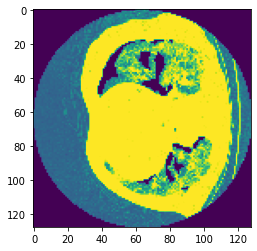

In [ ]:
arr = np.load(x_path[0])
plt.imshow(arr)

##CT Volume Z-score
Applying Z-score on CT volumes.

In [ ]:
def ReadNrrdVolume(path):
  imgdata,imgheader = nrrd.read(path)
  return imgdata

def SimpleMask(mskdata):
  new_msk = np.where(mskdata > 0, 1,0)
  return new_msk
  #np.min(new_msk),np.max(new_msk)

def MeanAndStdDev(mask,imgdata):
  data_arr = np.extract(mask,imgdata)
  mean = np.mean(data_arr)
  std_dev = np.std(data_arr)
  return mean,std_dev

def StandNormImage(imgdata,mean,std_dev):
  final_volume = (imgdata - mean)/std_dev
  return final_volume

def StandNormLungs(imgdata,mask,mean,std_dev):
  lung_seg = imgdata*mask
  final_volume = (lung_seg - mean)/std_dev
  return final_volume

def Downsample(arr,d_factor=4):
  return arr[::d_factor,::d_factor]

def SaveNumpyArray(arr,index,dir_path):
  fname = os.path.join(dir_path,f'CT_{str(index).zfill(2)}')
  save(fname,arr,allow_pickle=False, fix_imports=False)

In [ ]:
def merge(list1, list2):
      
    merged_list = [(list1[i], list2[i]) for i in range(0, len(list1))]
    return merged_list

volume_mask_list_path = merge(image_volume_path,mask_path)

In [ ]:
mean_l,std_dl=[],[]

In [ ]:
i=1
for volume,mask in volume_mask_list_path:
  imgdata = ReadNrrdVolume(volume)
  mskdata = ReadNrrdVolume(mask)
  simp_msk = SimpleMask(mskdata)
  #if(np.sum(simp_msk == 0)):
    #continue
  mean, std_dev = MeanAndStdDev(simp_msk,imgdata)
  mean_l.append(mean)
  std_dl.append(std_dev)
  #mean_list.append(mean)
  #std_dev_list.append(std_dev)
  #final_volume = StandNormLungs(imgdata,simp_msk,mean,std_dev)
  #SaveNumpyArray(final_volume,i,Numpy_array_path)
  i+=1
  

In [ ]:
from statistics import mean
test_mean = mean(mean_l)
test_std = mean(std_dl)


Saving Windowed 5 channel CT on disk

In [ ]:
def Downsample(arr,d_factor=4):
    return arr[::d_factor,::d_factor]

def CTWindow_LowRes(mskdata,index):
    arr1 = Downsample(mskdata[:,:,index-2])
    arr1 = np.expand_dims(arr1,axis=2)
    arr2 = Downsample(mskdata[:,:,index-1])
    arr2 = np.expand_dims(arr2,axis=2)
    arr3 = Downsample(mskdata[:,:,index])
    arr3 = np.expand_dims(arr3,axis=2)
    arr4 = Downsample(mskdata[:,:,index+1])
    arr4 = np.expand_dims(arr4,axis=2)
    arr5 = Downsample(mskdata[:,:,index+2])
    arr5 = np.expand_dims(arr5,axis=2)
    window_arr = np.concatenate((arr1,arr2,arr3,arr4,arr5),axis=2)
    return window_arr

In [ ]:
Zscore_volume_path = sorted(
    [
        os.path.join(Numpy_array_path , fname)
        for fname in os.listdir(Numpy_array_path )
        if fname.endswith(".npy")
    ]
)

Saving windowed arrays

In [ ]:
for path in Zscore_volume_path:
  fname = path[-9:-4]
  CT_array = load(path)
  for i in range(2,CT_array.shape[2]-3):
    target = CTWindow_LowRes(CT_array,i)
    highres_target = CT_array[:,:,i]
    save(os.path.join(window_target_path, fname+f'-{str(i).zfill(4)}'),target)
    save(os.path.join(highres_target_path,  fname+f'-{str(i).zfill(4)}'),highres_target)


## Creating DataPipelines

In [ ]:
class CustomDataGen(tf.keras.utils.Sequence):

  def __init__(self,x_path,y_path ,batch_size):
    self.x,self.y = x_path,y_path
    self.batch_size = batch_size  


  def __getinput(self,path):
    
    arr = np.load(path)
    return arr


  def __get_data(self,batch_x,batch_y):

    lowres_batch = [self.__getinput(path) for path in batch_x]
    highres_batch = [self.__getinput(path) for path in batch_y]

    return lowres_batch,highres_batch


  def __getitem__(self,idx):
    batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
    batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        
    X,y = self.__get_data(batch_x,batch_y)
    return np.asarray(X),np.asarray(y)


  def __len__(self):
    return len(self.x)//self.batch_size

In [ ]:
traingen = CustomDataGen(x_path=x_path,y_path=y_path,batch_size=16)
valgen = CustomDataGen(x_path=x_val_path,y_path=y_path_val,batch_size=16)

## U-NET

In [ ]:
inputs = tf.keras.layers.Input((None, None, 1))
s = tf.keras.layers.Resizing(512,512,interpolation='bicubic')(inputs)

c1 = tf.keras.layers.Conv2D(16,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16,(3,3),activation = 'relu',kernel_initializer='he_normal',padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2,2))(c1)

c2 = tf.keras.layers.Conv2D(32,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32,(3,3),activation = 'relu',kernel_initializer='he_normal',padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2,2))(c2)

c3 = tf.keras.layers.Conv2D(64,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.1)(c3)
c3 = tf.keras.layers.Conv2D(64,(3,3),activation = 'relu',kernel_initializer='he_normal',padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2,2))(c3)

c4 = tf.keras.layers.Conv2D(128,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.1)(c4)
c4 = tf.keras.layers.Conv2D(128,(3,3),activation = 'relu',kernel_initializer='he_normal',padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D((2,2))(c4)

c5 = tf.keras.layers.Conv2D(256,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.1)(c5)
c5 = tf.keras.layers.Conv2D(256,(3,3),activation = 'relu',kernel_initializer='he_normal',padding='same')(c5)

#Expansive Path

u6 = tf.keras.layers.Conv2DTranspose(128,(2,2),strides=(2,2),padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6,c4])
c6 = tf.keras.layers.Conv2D(128,(3,3),activation = 'relu',kernel_initializer='he_normal',padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128,(3,3),activation = 'relu', kernel_initializer='he_normal',padding='same')(c6)

u7 = tf.keras.layers.Conv2DTranspose(64,(2,2),strides=(2,2),padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7,c3])
c7 = tf.keras.layers.Conv2D(64,(3,3),activation = 'relu',kernel_initializer='he_normal',padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64,(3,3),activation = 'relu', kernel_initializer='he_normal',padding='same')(c7)

u8 = tf.keras.layers.Conv2DTranspose(32,(2,2),strides=(2,2),padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8,c2])
c8 = tf.keras.layers.Conv2D(32,(3,3),activation = 'relu',kernel_initializer='he_normal',padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.2)(c8)
c8 = tf.keras.layers.Conv2D(32,(3,3),activation = 'relu', kernel_initializer='he_normal',padding='same')(c8)

u9 = tf.keras.layers.Conv2DTranspose(16,(2,2),strides=(2,2),padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9,c1])
c9 = tf.keras.layers.Conv2D(16,(3,3),activation = 'relu',kernel_initializer='he_normal',padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.2)(c9)
c9 = tf.keras.layers.Conv2D(16,(3,3),activation = 'relu', kernel_initializer='he_normal',padding='same')(c9)

outputs = tf.keras.layers.Conv2D(1,(1,1),activation='linear')(c9)

model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam',loss='mse',metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 1)]                                                              
                                                                                                  
 resizing (Resizing)            (None, 512, 512, 1)  0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 16  160         ['resizing[0][0]']               
                                )                                                                 
                                                                                              

Callbacks

In [ ]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor="loss", patience=6)

checkpoint_filepath = "/tmp/checkpoint"

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor="loss",
    mode="min",
    save_best_only=True,
)

callbacks = [model_checkpoint_callback]

In [ ]:
model.fit(traingen,validation_data=valgen, epochs=1000,callbacks=callbacks)
model.save('/content/drive/MyDrive/COVID_19/Covid_norm_model_1000.h5')

Epoch 1/1000
3/3 [==============================] - 47s 8s/step - loss: 0.5175 - accuracy: 0.2101 - val_loss: 0.0206 - val_accuracy: 0.5563
Epoch 2/1000
3/3 [==============================] - 5s 2s/step - loss: 0.1172 - accuracy: 0.5193 - val_loss: 0.0130 - val_accuracy: 0.5579
Epoch 3/1000
3/3 [==============================] - 5s 2s/step - loss: 0.0778 - accuracy: 0.5380 - val_loss: 0.0158 - val_accuracy: 0.5579
Epoch 4/1000
3/3 [==============================] - 5s 2s/step - loss: 0.0553 - accuracy: 0.5217 - val_loss: 0.0274 - val_accuracy: 0.5572
Epoch 5/1000
3/3 [==============================] - 5s 2s/step - loss: 0.0537 - accuracy: 0.5198 - val_loss: 0.0161 - val_accuracy: 0.5579
Epoch 6/1000
3/3 [==============================] - 5s 2s/step - loss: 0.0445 - accuracy: 0.5361 - val_loss: 0.0078 - val_accuracy: 0.5584
Epoch 7/1000
3/3 [==============================] - 5s 2s/step - loss: 0.0415 - accuracy: 0.5459 - val_loss: 0.0074 - val_accuracy: 0.5586
Epoch 8/1000
3/3 [========

In [ ]:
model.save('Model_1.h5')

## Evaluation

In [ ]:
model = tf.keras.models.load_model('/content/Model_2_2.h5')
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 5  0           []                               
                                )]                                                                
                                                                                                  
 resizing (Resizing)            (None, 512, 512, 5)  0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 16  736         ['resizing[0][0]']               
                                )                                                                 
                                                                                              

In [ ]:
test_path = '/content/drive/MyDrive/Thesis_2/Test_window/'

test_path_list = sorted([
                         os.path.join(test_path,fname)
                         for fname in os.listdir(test_path)
                         if fname.endswith('npy')
])

In [ ]:
test_ctmask_path = '/content/drive/MyDrive/Thesis_2/Test_highres/'
test_mask_path = '/content/drive/MyDrive/Thesis_2/Test_mask/'

test_ctmask_path_list = sorted([
                         os.path.join(test_ctmask_path,fname)
                         for fname in os.listdir(test_ctmask_path)
                         if fname.endswith('.npy')
])

print(len(test_ctmask_path_list))

3023


In [ ]:
#saving numpy array of mask on disk
for fname in test_ctmask_path_list:
  mskdata,mskheader = nrrd.read(fname)
  for i in range(2,mskdata.shape[2]-3):
    mask_array = mskdata[:,:,i]
    file_name = fname[-18:-5]
    save(os.path.join(test_mask_path, file_name+f'-{str(i).zfill(4)}'),mask_array)

In [ ]:
high = load('/content/drive/MyDrive/Thesis_2/Test_highres/CT_01-0002.npy')
high = np.expand_dims(high,axis=-1)
pred[0].shape,high.shape
score = ssim(pred[0],high,multichannel=True)
print(score)

In [ ]:
from skimage.metrics import structural_similarity as ssim
from math import log10
from math import sqrt
from sklearn.metrics import mean_absolute_percentage_error as mape

def GetUpsampledLR(lowres_np):
  lowres_0 = lowres_np[:,:,0]
  lr_ups0 = cv2.resize(lowres_0, (512,512), interpolation=cv2.INTER_CUBIC)
  lr_ups0 = np.expand_dims(lr_ups0,axis=-1)
  #
  lowres_1 = lowres_np[:,:,1]
  lr_ups1 = cv2.resize(lowres_1, (512,512), interpolation=cv2.INTER_CUBIC)
  lr_ups1 = np.expand_dims(lr_ups1,axis=-1)  
  #
  lowres_2 = lowres_np[:,:,2]
  lr_ups2 = cv2.resize(lowres_2, (512,512), interpolation=cv2.INTER_CUBIC)
  lr_ups2 = np.expand_dims(lr_ups2,axis=-1)
  #
  lowres_3 = lowres_np[:,:,3]
  lr_ups3 = cv2.resize(lowres_3, (512,512), interpolation=cv2.INTER_CUBIC)
  lr_ups3 = np.expand_dims(lr_ups3,axis=-1)
  #
  lowres_4 = lowres_np[:,:,4]
  lr_ups4 = cv2.resize(lowres_4, (512,512), interpolation=cv2.INTER_CUBIC)
  lr_ups4 = np.expand_dims(lr_ups4,axis=-1)

  final_windowed_ups_lr = np.concatenate((lr_ups0,lr_ups1,lr_ups2,lr_ups3,lr_ups4),axis=-1)
  return final_windowed_ups_lr


def PredictImage(lowres_path,model):
  lowres = load(lowres_path)
  lowres = GetUpsampledLR(lowres)
  #lowres = np.repeat(lowres, 4, axis=0).repeat(4, axis=1)
  lowres = np.expand_dims(lowres,axis=0)
  prediction = model.predict(lowres)
  predict_np = prediction[0]
  predicted_np = np.squeeze(predict_np,axis=2)
  return predicted_np

def GetHighResImage(path):
  highres_np = load(path)
  #highres_np = np.expand_dims(highres_np,axis=-1)
  return highres_np

def GetMask(path):
  mask = load(path)
  #mask = np.expand_dims(mask,axis=-1)
  return mask

def Lung(mask):
  Lung_mask = np.where(mask>0,1,0)
  return Lung_mask

def Get_Normal_lungs(lung_mask,GGO_mask,conso_mask):
  temp_mask = GGO_mask + conso_mask
  Normal_lungs = lung_mask - temp_mask
  return Normal_lungs

def GGO(mask):
  GGO_mask = np.where(mask==3,1,0)
  return GGO_mask

def Consolidation(mask):
  conso_mask = np.where(mask==4,1,0)
  return conso_mask

def Calculate_ssim(ssmap,mask):
  temp = np.extract(mask,ssmap)
  return np.mean(temp)

def Rescale_uint8(arr):
  arr_uint8 = (arr - np.min(arr))/(np.max(arr) - np.min(arr))
  arr = arr_uint8*255
  return arr.astype('uint8')

def PSNR(original,compressed,mask):
    compressed = Rescale_uint8(compressed)
    original = Rescale_uint8(original)
    y_pred = np.extract(mask,compressed)
    y_actual = np.extract(mask,original)
    mse = ((y_actual-y_pred) ** 2)/y_actual.shape[0]
    if(mse == 0):  
      return 100
    max_pixel = 255.0
    psnr = 20 * log10(max_pixel / sqrt(mse))
    return psnr
  
def LocalMAPE(original,compressed,mask):
  y_pred = np.extract(mask,compressed)
  y_actual = np.extract(mask,original) 
  local_mape = mape(y_actual,y_pred)
  return local_mape

def lin_reg(pred_np,highres_path):
  pred_np =Downsample(pred_np,d_factor=4)
  hr = load(highres_path)
  lr = Downsample(hr,d_factor=4)
  x = np.reshape(pred_np,(-1,1))
  y = np.reshape(lr,(-1,1))
  reg = LinearRegression().fit(x,y)
  return reg.coef_[0],reg.intercept_

def custom_ssim(img1, img2):
    C1 = (0.01 * 255)**2
    C2 = (0.03 * 255)**2
    C3 = C2/2
    
    img1 = img1.astype(np.float64)
    img2 = img2.astype(np.float64)
    kernel = cv2.getGaussianKernel(11, 1.5)
    window = np.outer(kernel, kernel.transpose())

    mu1 = cv2.filter2D(img1, -1, window)[5:-5, 5:-5]  # valid
    mu2 = cv2.filter2D(img2, -1, window)[5:-5, 5:-5]
    mu1_sq = mu1**2
    mu2_sq = mu2**2
    mu1_mu2 = mu1 * mu2
    sigma1_sq = cv2.filter2D(img1**2, -1, window)[5:-5, 5:-5] - mu1_sq
    sigma2_sq = cv2.filter2D(img2**2, -1, window)[5:-5, 5:-5] - mu2_sq
    sigma12 = cv2.filter2D(img1 * img2, -1, window)[5:-5, 5:-5] - mu1_mu2

    #ssim_map = ((2 * mu1_mu2 + C1) * (2 * sigma12 + C2)) / ((mu1_sq + mu2_sq + C1) *
                                                                #(sigma1_sq + sigma2_sq + C2))
    
    luminance = (2*mu1*mu2 + C1)/(mu1_sq + mu2_sq + C1)
    
    contrast = (2*sqrt(sigma1_sq)*sqrt(sigma2_sq) + C2)/(sigma1_sq + sigma2_sq + C2) 
    
    structure = (sigma12 + C3)/(sqrt(sigma1_sq)*sqrt(sigma2_sq) + C3)
    
    return luminance,contrast,structure

In [ ]:
#merging window,highres and mask path into one list
test_window_path = '/content/drive/MyDrive/Thesis_2/Testing_subset/Windowed_arrays/'
test_highres_path = '/content/drive/MyDrive/Thesis_2/Testing_subset/Highres_arrays/'
test_mask_path = '/content/drive/MyDrive/Thesis_2/Testing_subset/Mask_arrays/'

test_window_path_list = sorted([
                         os.path.join(test_window_path,fname)
                         for fname in os.listdir(test_window_path)
                         if fname.endswith('.npy')
])

test_highres_path_list = sorted([
                         os.path.join(test_highres_path,fname)
                         for fname in os.listdir(test_highres_path)
                         if fname.endswith('.npy')
])

test_mask_path_list = sorted([
                         os.path.join(test_mask_path,fname)
                         for fname in os.listdir(test_mask_path)
                         if fname.endswith('.npy')
])

merged_list = [(test_window_path_list[i], test_highres_path_list[i],test_mask_path_list[i]) for i in range(0, len(test_window_path_list))]

# For full test set

In [ ]:
Normal_ssim_list,lungs_ssim_list,mape_list,psnr_list = [],[],[],[]
for lowres,highres,mask_path in merged_list:
  predicted_np = PredictImage(lowres,model)
  w1,b = lin_reg(predicted_np,highres)
  predicted_np = w1*predicted_np + b
  highres_np = GetHighResImage(highres)
  mask = GetMask(mask_path)
  if(np.sum(mask)==0):
    continue
  else:  
    Lung_mask = Lung(mask)
    GGO_mask = GGO(mask)
    conso_mask = Consolidation(mask)
    Normal_lungs_mask = Get_Normal_lungs(Lung_mask,GGO_mask,conso_mask)
    t_ssim,ssmap = ssim(predicted_np,highres_np,full=True,sigma=1.5,win_size=11)
    localmape = LocalMAPE(highres_np,predicted_np,Normal_lungs_mask)
    #localpsnr = PSNR(highres_np,predicted_np,Normal_lungs_mask)
    Normal_ssim = Calculate_ssim(ssmap,Normal_lungs_mask)
    Lung_ssim = Calculate_ssim(ssmap,Lung_mask)
    #GGO_ssim = Calculate_ssim(ssmap,GGO_mask)
    #conso_ssim = Calculate_ssim(ssmap,conso_mask)
    #test_GGO_ssim.append(GGO_ssim)
    #test_conso_ssim.append(conso_ssim)
    Normal_ssim_list.append(Normal_ssim)
    lungs_ssim_list.append(Lung_mask)
    mape_list.append(localmape)
    psnr_list.append(localmape)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launch

In [ ]:
import math
from statistics import mean
#GGO_score = mean(test_GGO_ssim)
#conso_score = mean(test_conso_ssim)
Normal_ssim_list.pop(1)
lung_score = sum(Normal_ssim_list)/len(Normal_ssim_list)
mape_score = sum(mape_list)/len(mape_list)
lung_ssim_score = sum(lungs_ssim_list)/len(lungs_ssim_list)
#print("GGO score: ",GGO_score)
#print("conso score: ",conso_score)
print("Normal Lung SSIM score: ",lung_score)
print("MAPE score: ",mape_score)
print("Lungs score: ",lung_ssim_score)
for i in range(len(Normal_ssim_list)):
  if(math.isnan(Normal_ssim_list[i])):
    print(i)
  else:
    continue

Normal Lung SSIM score:  0.4887832234326468
MAPE score:  0.37979633661325896
Lungs score:  [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [ ]:
#saving all ssim score for normal lungs in a file using pickle
import pickle
file_name = "Normal_ssim_list_2.pkl"

open_file = open(file_name,"wb")
pickle.dump(Normal_ssim_list,open_file)
open_file.close()


# For single slice

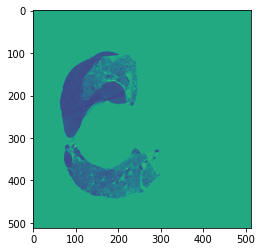

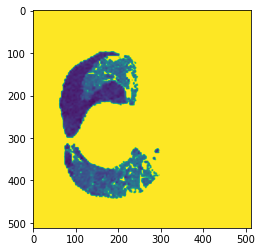

(-3.5394063, 0.3907643, -2.683779277983387, 4.486425257446565)

In [ ]:
arr_path = '/content/drive/MyDrive/Thesis_2/Test_window/CT_02-0400.npy'
highres_path = '/content/drive/MyDrive/Thesis_2/Test_highres/CT_02-0400.npy'
mask_path = '/content/drive/MyDrive/Thesis_2/Test_mask/GMM_LABELS_75-0400.npy'

#arr = np.expand_dims(arr_path,axis=0)
predicted_np = PredictImage(arr_path,model)
highres_np = GetHighResImage(highres_path)

plt.imshow(highres_np)
plt.show()
predicted_np = (predicted_np - np.mean(predicted_np))/np.std(predicted_np)
plt.imshow(predicted_np)
plt.show()
np.min(predicted_np),np.max(predicted_np),np.min(highres_np),np.max(highres_np)

#mask = GetMask(mask_path)
#GGO_mask = GGO(mask)
#conso_mask = Consolidation(mask)
#t_ssim,ssmap = ssim(predicted_np,highres_np,full=True)
#GGO_ssim = Calculate_ssim(ssmap,GGO_mask)
#conso_ssim = Calculate_ssim(ssmap,conso_mask)
#print(GGO_ssim,conso_ssim,t_ssim)


## Single Slice Test Subset 128x128x5(Input shape)

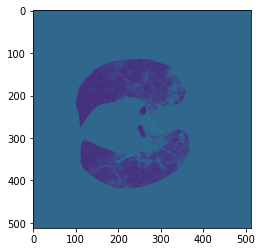

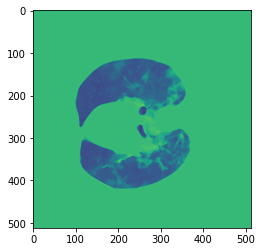

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.


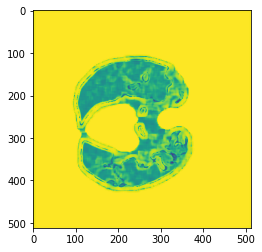

0.3724166327568321 0.47444723493488955 0.8434736526308411


-1.9673917

In [ ]:
arr_path = '/content/drive/MyDrive/Thesis_2/Testing_subset/Windowed_arrays/CT_01-0401.npy'
highres_path = '/content/drive/MyDrive/Thesis_2/Testing_subset/Highres_arrays/CT_01-0401.npy'
mask_path = '/content/drive/MyDrive/Thesis_2/Testing_subset/Mask_arrays/GMM_LABELS_79-0401.npy'

#arr = np.expand_dims(arr_path,axis=0)
predicted_np = PredictImage(arr_path,model)
highres_np = GetHighResImage(highres_path)

#predicted_np = (predicted_np - np.min(predicted_np))/(np.max(predicted_np)-np.min(predicted_np))
#highres_np = (highres_np - np.min(highres_np))/(np.max(highres_np)-np.min(highres_np))

plt.imshow(highres_np)
plt.show()
#predicted_np = (predicted_np - np.mean(predicted_np))/np.std(predicted_np)
plt.imshow(predicted_np)
plt.show()
np.min(predicted_np),np.max(predicted_np),np.min(highres_np),np.max(highres_np)


mask = GetMask(mask_path)
GGO_mask = GGO(mask)
conso_mask = Consolidation(mask)
t_ssim,ssmap = ssim(predicted_np,highres_np,full=True,win_size=11,sigma=1.5)
plt.imshow(ssmap)
plt.show()
GGO_ssim = Calculate_ssim(ssmap,GGO_mask)
conso_ssim = Calculate_ssim(ssmap,conso_mask)
print(GGO_ssim,conso_ssim,t_ssim)
np.min(predicted_np)

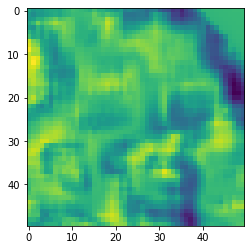

array([[-9.10015922e-02, -1.66270466e-01, -1.28458953e-01, ...,
        -2.72889304e-05,  2.45019804e-03,  7.36987051e-03],
       [-1.53802864e-01, -2.09101110e-01, -1.46483511e-01, ...,
        -2.29415148e-03, -6.65125985e-04,  2.09767999e-03],
       [-1.60989766e-01, -1.26954877e-01, -4.93124776e-02, ...,
        -4.08371756e-03, -2.76607523e-03, -8.60987551e-04],
       ...,
       [ 7.31327094e-02,  4.35027374e-02,  4.33526940e-02, ...,
         7.21242615e-02,  4.52005068e-02,  1.31310884e-02],
       [-3.14990300e-02, -2.61334413e-02, -7.29469212e-02, ...,
         3.78252516e-02,  4.17133021e-02,  4.00693121e-02],
       [-1.07833240e-01, -1.42913992e-01, -1.79349939e-01, ...,
         2.11741185e-02,  5.15110081e-02,  6.38899938e-02]])

In [ ]:
plt.imshow(ssmap[150:200,300:350])
plt.show()
ssmap[150:200,300:350]

# Local SSIM 

In [ ]:
      array = load('/content/drive/MyDrive/Thesis_2/Test_highres/CT_01-0400.npy')
      mask = load('/content/drive/MyDrive/Thesis_2/Test_mask/GMM_LABELS_74-0400.npy')
      #array = np.expand_dims(array,axis=-1)
      row,col= array.shape
      mean = 0
      var = 0.05
      sigma = var**0.5
      gauss = np.random.normal(mean,sigma,(row,col))
      gauss = gauss.reshape(row,col)
      #mask = np.zeros_like(array)
      #mask[200:300,180:310] = 1
      #gauss = gauss*mask
      noisy = array + gauss
      noisy = mask*noisy
      array = mask*array
      np.min(array),np.max(array)

(-3.62926525497908, 42.69220951566507)

In [ ]:
ssim_score,ssmap = ssim(noisy,array,full=True)
ssim_score

0.9719162611841468

In [ ]:
ss = np.extract(mask,ssmap)
ss.mean()

0.7830301887748288